# Importing Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

# Some constants
lr = 0.002
batch_size = 64
epochs = 100
img_shape = (112, 112, 3)
latent_dim = 100

# Building the models

## 1. Generator

In [32]:
def make_generator():
    l2 = regularizers.l2(l2=1e-4)
    inputs = Input(shape=(latent_dim,))
    
    x = Dense(7*7*256, use_bias=False, kernel_regularizer=l2)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape(target_shape=(7,7,256))(x)
    
    # Size = 128 x 14 x 14 
    x = Conv2DTranspose(128, kernel_size=5, strides=(2,2), padding='same',
                        use_bias=False, kernel_regularizer=l2)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    # Size = 64 x 28 x 28
    x = Conv2DTranspose(64, kernel_size=5, strides=(2,2), padding='same',
                       use_bias=False, kernel_regularizer=l2)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    # Size = 32 x 56 x 56
    x = Conv2DTranspose(32, kernel_size=5, strides=(2,2), padding='same',
                       use_bias=False, kernel_regularizer=l2)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    # Size = 16 x 112 x 112
    x = Conv2DTranspose(16, kernel_size=5, strides=(2,2), padding='same',
                       use_bias=False, kernel_regularizer=l2)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    # Use tanh so that it is [-1, 1]
    x = Conv2D(img_shape[-1], kernel_size=5, padding='same', use_bias=False, activation='tanh')(x)
    
    model = Model(inputs=inputs, outputs=x, name='Generator')
    return model

G = make_generator()
G.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_10 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 128)       819200    
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 14, 128)       51

## 2. Discriminator

In [26]:
def make_discriminator():
    inputs = Input(shape=img_shape)
    
    x = Conv2D(16, kernel_size=5, strides=(2,2), padding='same')(inputs)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(32, kernel_size=5, strides=(2,2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, kernel_size=5, strides=(2,2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, kernel_size=5, strides=(2,2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=x, name='Discriminator')
    return model

D = make_discriminator()
D.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 16)        1216      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 56, 56, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        12832     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 28, 28, 32)      

# Definition of loss functions

## 1. Generator Loss

In [27]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

'''
    Evaluates how well the Generator can deceive the Discriminator
    Calculated by taking the binary cross entropy of D(G(z)) w.r.t ones
'''
def generator_loss(D_fake):
    return bce(tf.ones_like(D_fake), D_fake)

## 2. Discriminator Loss

In [28]:
'''
    Evaluates how well the discriminator is able to separate true and fake instances
    Calculated by taking the sume of bce(D(G(z)), 0) and bce(D(x), 1)
'''
def discriminator_loss(D_true, D_fake):
    fake_loss = bce(tf.zeros_like(D_fake), D_fake)
    true_loss = bce(tf.ones_like(D_true), D_true)
    
    return fake_loss + true_loss

# Preparing the dataset

Found 202599 images belonging to 10177 classes.


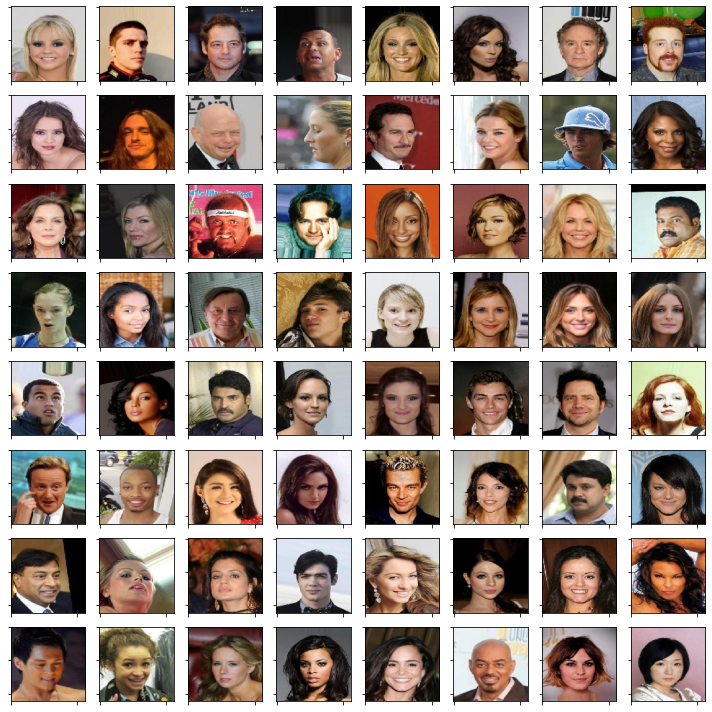

In [29]:
def preprocess(img):
    # normalize
    img = (img - 127.5) / 127.5
    img = img.astype(np.float32)
    
    return img
    
generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess)
dataset = generator.flow_from_directory("/home/minhhieu/Desktop/Hieu/datasets/img_align_celeba",
                                       target_size=(img_shape[0], img_shape[1]),
                                       batch_size=batch_size)
dataset_size = len(dataset)
steps_per_epoch = dataset_size // batch_size

# Display sample images
batchX, batchY = next(dataset)
grid_size = int(np.sqrt(batch_size))

fig, ax = plt.subplots(grid_size, grid_size, figsize=(10, 10))
for i in range(batch_size):
    row = i // grid_size
    col = i %  grid_size
    
    img = ((batchX[i] * 127.5) + 127.5).astype(np.uint8)
    
    ax[row][col].set_xticklabels([])
    ax[row][col].set_yticklabels([])
    ax[row][col].imshow(img)
    
plt.tight_layout()
plt.show()

# Start the training process

In [30]:
# Define the optimizers
g_opt = optimizers.Adam(learning_rate=lr, amsgrad=True)
d_opt = optimizers.Adam(learning_rate=lr, amsgrad=True)

# Define training step per batch
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])
    
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_img = G(noise, training=True)
        
        real_output = D(fake_img, training=True)
        fake_output = D(images, training=True)
        
        g_loss = generator_loss(fake_output)
        d_loss = discriminator_loss(real_output, fake_output)
        
        print(g_loss, d_loss)
        
    g_gradient = g_tape.gradient(g_loss, G.trainable_variables)
    d_gradient = d_tape.gradient(d_loss, D.trainable_variables)
    
    print(g_gradient)
    g_opt.apply_gradients(zip(g_gradient, G.trainable_variables))
    d_opt.apply_gradients(zip(d_gradient, D.trainable_variables))
    
    return g_loss, d_loss

In [33]:
# Define the training loop
for epoch in range(epochs):
    for batchX, batchY in dataset:
        g_loss, d_loss = train_step(batchX)

tf.Tensor(0.7084451, shape=(), dtype=float32) tf.Tensor(1.3940432, shape=(), dtype=float32)
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


ValueError: No gradients provided for any variable: ['dense_4/kernel:0', 'batch_normalization_10/gamma:0', 'batch_normalization_10/beta:0', 'conv2d_transpose_8/kernel:0', 'batch_normalization_11/gamma:0', 'batch_normalization_11/beta:0', 'conv2d_transpose_9/kernel:0', 'batch_normalization_12/gamma:0', 'batch_normalization_12/beta:0', 'conv2d_transpose_10/kernel:0', 'batch_normalization_13/gamma:0', 'batch_normalization_13/beta:0', 'conv2d_transpose_11/kernel:0', 'batch_normalization_14/gamma:0', 'batch_normalization_14/beta:0', 'conv2d_10/kernel:0'].